# Team performance as a function of FIFA 2015 Attributes

In this data challenge, I'll be looking at data from the Kaggle European Soccer Database: https://www.kaggle.com/hugomathien/soccer 

<img src="https://pixabay.com/static/uploads/photo/2014/03/18/20/21/man-290186_1280.jpg" alt="Drawing" style="width: 600px;"/>

In [1]:
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them
import sqlite3#Used to access database
import pandas as pd#Used to load data as dataframes
import numpy as np#Used for math and array operations
import matplotlib.pyplot as plt#Used for plotting
import seaborn as sns#Also used for plotting, friendly with dataframes

## Feature Engineering with SQL

One thing that I've always wondered about the FIFA games series is how accurate their team metrics are compared to soccer in real life. Thus, I decided to find what attributes have are the best predictors for team performance (winning percentage). 

In [192]:
#Create connection to SQLite database
con= sqlite3.connect('fifa_data.sqlite')

#Use pandas to query database
data= pd.read_sql_query('''

select team_record.*, team_attributes.*
from (
select team, sum(goals_for) as total_goals_for, sum(goals_against) as total_goals_against, sum(win) as total_wins, sum(loss) as total_losses, sum(draw) as total_draws
from (select *,
	CASE WHEN diff <0 THEN 1 ELSE 0 END as loss, 
	CASE WHEN diff = 0 THEN 1 ELSE 0 END as draw,
	CASE WHEN diff > 0 THEN 1 ELSE 0 END as win 

from (select date, home_team_api_id as team, home_team_goal as goals_for, away_team_goal as goals_against, home_team_goal-away_team_goal as diff 
from Match
UNION
select date, away_team_api_id as team, away_team_goal as goals_for, home_team_goal as goals_against, away_team_goal-home_team_goal as diff 
from Match
order by team) 
)

group by team) team_record
join team_attributes
on team_record.team = team_attributes.team_api_id
where date > 2015
order by team

''',con)

In [196]:
data.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,id,team_fifa_api_id,team_api_id,date,...,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1601,280,292,92,91,57,1300,874,1601,2015-08-28 00:00:00,...,36,Normal,Organised,46,Medium,44,Balanced,64,Normal,Cover
1,1773,126,162,22,40,28,1100,100087,1773,2015-08-28 00:00:00,...,54,Normal,Organised,43,Medium,44,Balanced,50,Normal,Cover
2,1957,287,315,87,89,64,740,110745,1957,2015-08-28 00:00:00,...,66,Normal,Organised,53,Medium,62,Fast,44,Normal,Cover


In [194]:
#Can't use PCA with categorical data so let's remove the columns that have non-numeric data and keep the team names
dataNum= data._get_numeric_data()

In [195]:
print dataNum.shape
dataNum.dtypes

(241, 17)


team                      int64
total_goals_for           int64
total_goals_against       int64
total_wins                int64
total_losses              int64
total_draws               int64
id                        int64
team_fifa_api_id          int64
team_api_id               int64
buildUpPlaySpeed          int64
buildUpPlayDribbling      int64
buildUpPlayPassing        int64
chanceCreationPassing     int64
chanceCreationCrossing    int64
defencePressure           int64
defenceAggression         int64
defenceTeamWidth          int64
dtype: object

In [197]:
dataNum= dataNum.drop(['id','team_fifa_api_id','team_api_id'], axis=1)
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44


The last thing we want to add is a win percentage. However, since we have draws, I'll account for them as half a win. Thus, win percentage will be (total_wins+0.5*total_draws)/(total_wins+total_losses+total_draws). See reference here: https://en.wikipedia.org/wiki/Winning_percentage

In [202]:
dataNum['win_pctg'] = (dataNum['total_wins']+0.5*dataNum['total_draws'])/(dataNum['total_wins']+dataNum[
        'total_losses']+dataNum['total_draws'])

In [203]:
dataNum.head(3)

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
0,1601,280,292,92,91,57,47,57,44,58,36,46,44,64,0.502083
1,1773,126,162,22,40,28,52,51,50,50,54,43,44,50,0.400000
2,1957,287,315,87,89,64,70,54,37,64,66,53,62,44,0.495833


In [204]:
dataNum.describe()

,team,total_goals_for,total_goals_against,total_wins,total_losses,total_draws,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,defencePressure,defenceAggression,defenceTeamWidth,win_pctg
count,241.00000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.00000,241.000000,241.000000,241.000000,241.000000
mean,12865.40249,266.622407,256.095436,74.228216,69.373444,48.792531,53.560166,48.178423,50.431535,51.634855,51.53112,46.614108,49.896266,52.190871,0.472854
std,28141.11618,173.367873,118.920366,52.526281,32.824812,24.509150,8.646140,9.118966,9.435553,9.428650,10.36340,9.468173,8.744142,8.208537,0.121250
min,1601.00000,22.000000,38.000000,3.000000,13.000000,4.000000,30.000000,27.000000,30.000000,29.000000,23.00000,25.000000,29.000000,29.000000,0.210526
25%,8388.00000,118.000000,162.000000,27.000000,43.000000,29.000000,48.000000,41.000000,44.000000,47.000000,46.00000,40.000000,44.000000,48.000000,0.400000
50%,8658.00000,247.000000,272.000000,69.000000,71.000000,53.000000,54.000000,48.000000,51.000000,52.000000,52.00000,46.000000,49.000000,52.000000,0.447368
75%,9885.00000,390.000000,346.000000,107.000000,96.000000,69.000000,60.000000,55.000000,56.000000,58.000000,59.00000,53.000000,57.000000,58.000000,0.525735
max,274581.00000,849.000000,471.000000,234.000000,142.000000,100.000000,73.000000,70.000000,76.000000,75.000000,80.00000,72.000000,72.000000,69.000000,0.840461


Great, they're all numeric so sklearn should be able to handle it. Now let's see what the statistics look like for each column to see if anything fishy/interesting pops out.

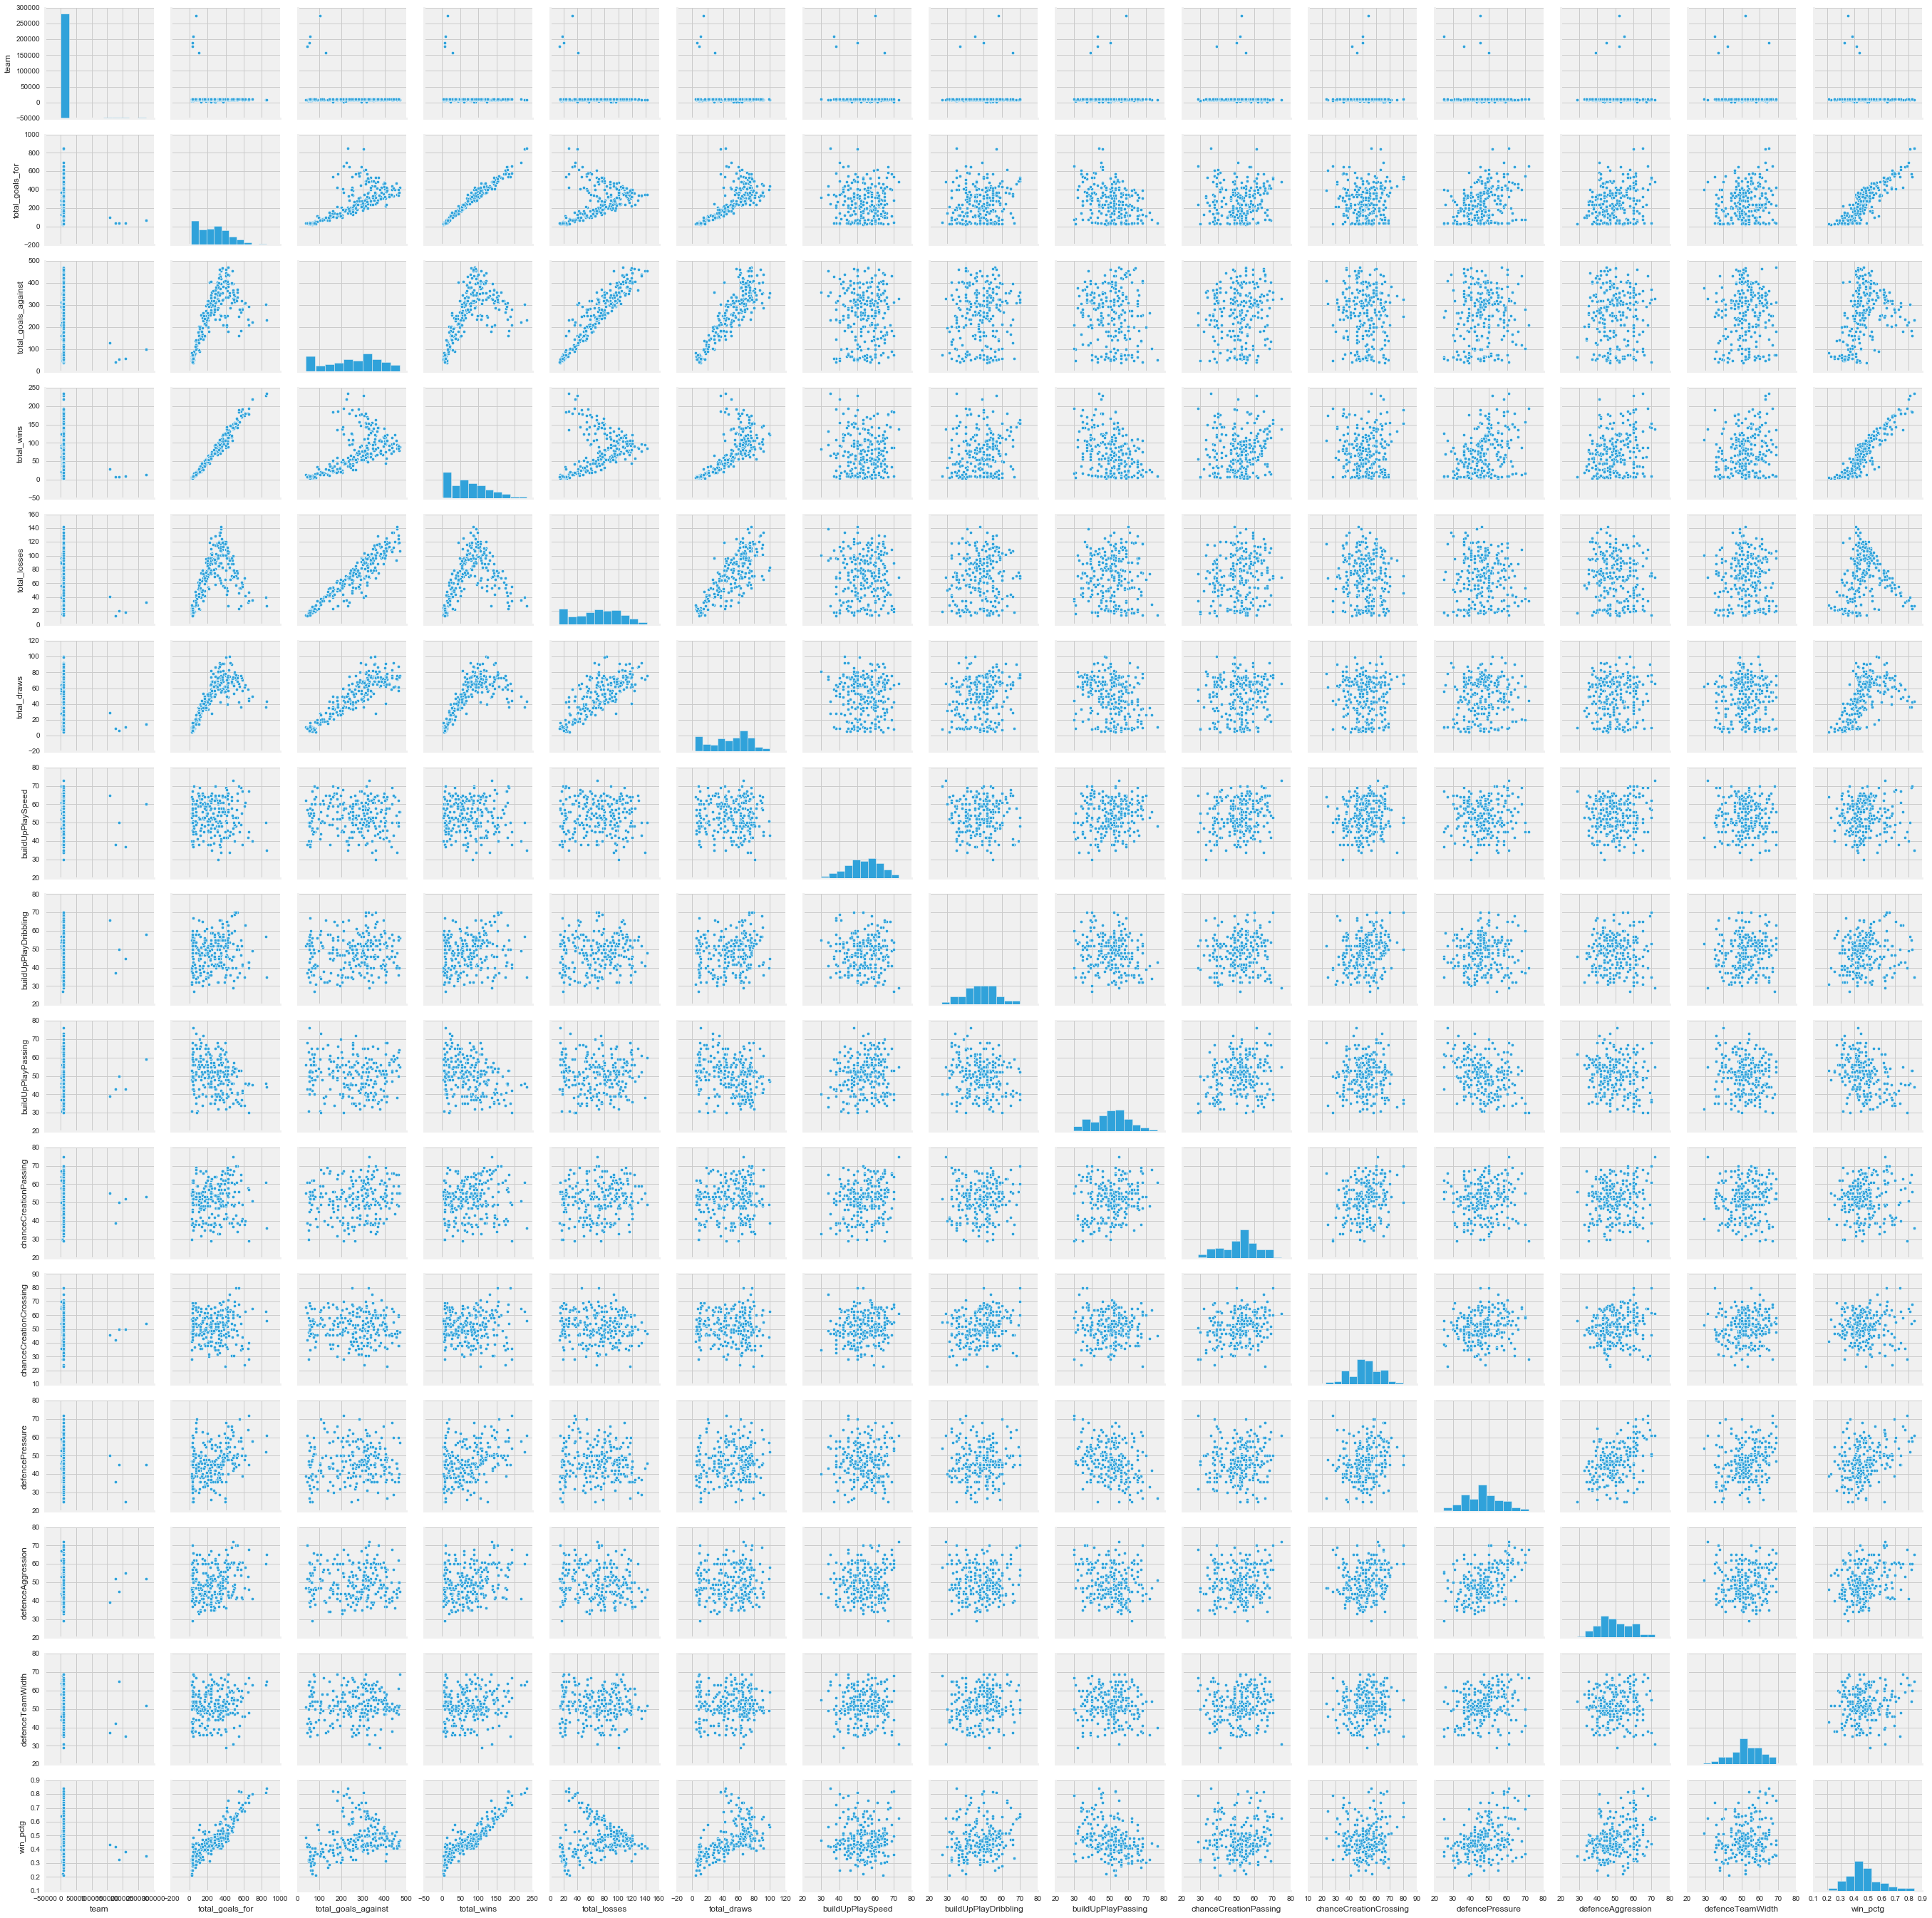

In [241]:
sns.pairplot(dataNum)
#g.map_diag(plt.hist)

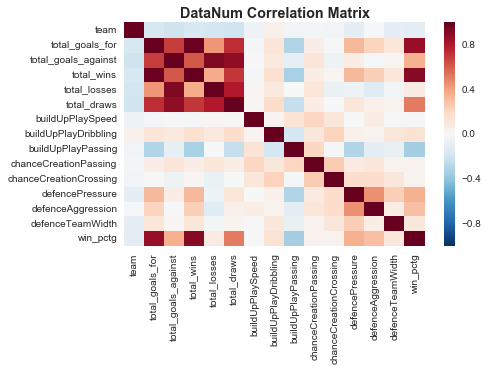

In [236]:
sns.heatmap(dataNum.corr())#, cmap= 'viridis')
#plt.colorbar(label='Pearson Corr. Coeff.')
plt.title('DataNum Correlation Matrix', fontweight= 'bold')

## PCA

In [222]:
from sklearn import preprocessing

feats= dataNum.ix[:, dataNum.columns != 'team']
feats= feats.ix[:, feats.columns != 'win_pctg']
target= dataNum['win_pctg']

featsScaled= preprocessing.scale(feats)
featsScaled

array([[ 0.07732364,  0.30254942,  0.33904495, ..., -0.06499522,
        -0.67571368,  1.44163389],
       [-0.81280957, -0.79289417, -0.99639476, ..., -0.38250563,
        -0.67571368, -0.26745703],
       [ 0.11778424,  0.49635867,  0.2436564 , ...,  0.67586241,
         1.38709134, -0.99992456],
       ..., 
       [-1.34457745, -1.70295499, -1.26348271, ..., -0.17083202,
        -0.5611134 ,  1.56371181],
       [-1.3272372 , -1.67767552, -1.244405  , ..., -2.28756809,
         0.58488939, -2.09862586],
       [-1.13071428, -1.29848351, -1.14901645, ..., -0.17083202,
         0.24108855, -0.02330118]])

In [223]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.9)
pca.fit(featsScaled)

#After ranking the features by the magnitude of their eigenvalues (larger= lar)
pcaFeats = pca.transform(featsScaled)

In [232]:
print 'Number of features before feature reduction: ', featsScaled.shape
print 'Number of features after feature reduction: ', pcaFeats.shape

Number of features before feature reduction:  (241, 13)
Number of features after feature reduction:  (241, 8)


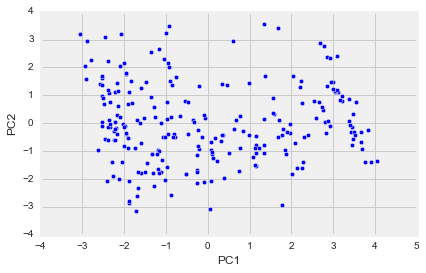

In [228]:
plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [242]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(pcaFeats) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [244]:
k_means.labels_

array([1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0,
       1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0,
       0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 0, 0, 1,
       1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2, 2,
       2, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0,
       2, 1, 2, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1, 2, 0, 1, 2,
       2, 1, 0, 0, 0, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1,
       1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0], dtype=int32)

In [263]:
cluster0= []; cluster1= []; cluster2= []
for i in range(0,len(k_means.labels_)):
    if k_means.labels_[i] == 0: cluster0.append(pcaFeats[i,:])
    elif k_means.labels_[i] == 1: cluster1.append(pcaFeats[i,:])
    elif k_means.labels_[i] == 2: cluster2.append(pcaFeats[i,:])


In [280]:
cluster0= np.array(cluster0)
cluster1= np.array(cluster1)
cluster2= np.array(cluster2)

<IPython.core.display.Javascript object>


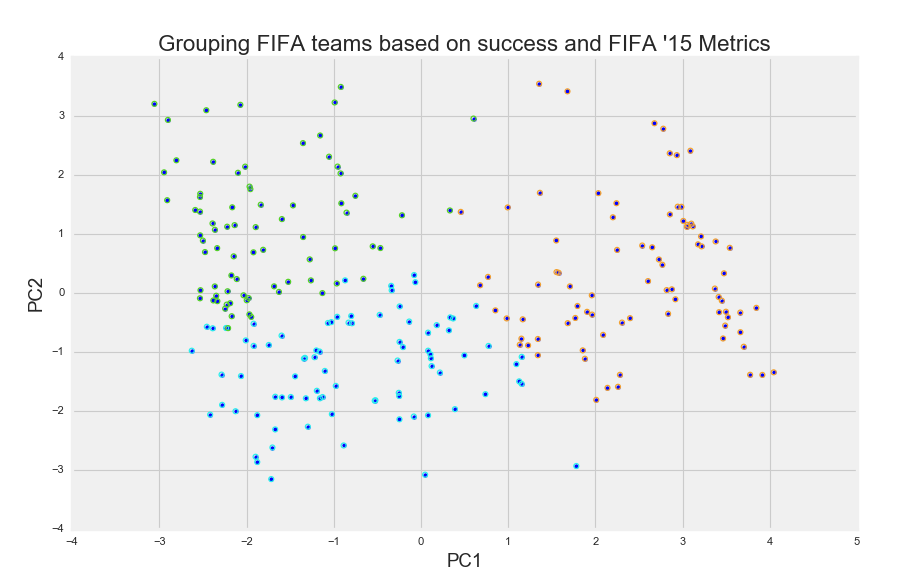

In [292]:
%matplotlib nbagg

plt.scatter(pcaFeats[:,0], pcaFeats[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

clusters= [cluster0, cluster1, cluster2]
colors= ['r','y','g']

plt.style.use('fivethirtyeight')

plt.scatter(cluster0[:,0], cluster0[:,1], color= '#f2a02e', facecolor= 'None', 
                           linewidths= 1.1)
plt.scatter(cluster1[:,0], cluster1[:,1], color= '#28eded', facecolor= 'None', 
                           linewidths= 1.1)
plt.scatter(cluster2[:,0], cluster2[:,1], color= '#54d127', facecolor= 'None', 
                           linewidths= 1.1)

plt.title("Grouping FIFA teams based on success and FIFA '15 Metrics")

In [257]:
clusters[0][:,1]

TypeError: list indices must be integers, not tuple

## Splitting Data 

The first thing that I'll want to do is identify some type of target variable. The most obvious one seems to be 'amount_purchased'. We'll keep this column separate from the others and keep the customer id separate as well. 

To begin with we'll need to split our data into a few groups: training, testing sets. From the training we'll then split that into a training and validation set.

In [9]:
from sklearn.cross_validation import KFold, train_test_split

In [10]:
#Now we'll split our data first into training/testing (wel'll further divide testing into validation, real test)
#random_state sets seed
train, validTest= train_test_split(cleanData, test_size= 0.5, random_state= 42)

In [11]:
#Now split the validTest into a test dataset and a validation set (in half again)
test, validation= train_test_split(validTest, test_size= 0.5, random_state= 42)

Now that we have this taken care of, we can do visualization and any other transformations on the training set without worrying about having observed some of our test/validation set (in case it poisons our analysis in any way).

## Visualizing Data

Let's first look at how far customers have to travel to reach the different shops. Then, we'll determine how distance affects customers spending habits at each store.

In [12]:
#Let's remember what our dataset holds
train.head(3)

,customer_id,avg_distance_to_shops,min_distance_to_shops,max_distance_to_shops,products_purchased,unique_products_purchased,amount_purchased,avg_purchase,avg_price,shops_used,...,avg_purchase_shop_1,avg_purchase_shop_2,avg_purchase_shop_3,avg_purchase_shop_4,avg_purchase_shop_5,avg_price_shop_1,avg_price_shop_2,avg_price_shop_3,avg_price_shop_4,avg_price_shop_5
38277,38278,1525.1019,442.54196,2862.7542,379.0,172.0,861.156,3.844446,2.440040,4.0,...,4.413072,3.597323,2.011222,0.0,2.018571,2.627198,2.300221,2.011222,0.0,1.953619
2842,2843,3009.2363,3009.23630,3009.2363,1.0,1.0,2.312,2.312000,2.312000,1.0,...,2.312000,0.000000,0.000000,0.0,0.000000,2.312000,0.000000,0.000000,0.0,0.000000
21266,21267,2128.2830,2128.28300,2128.2830,86.0,69.0,937.066,13.580667,12.438464,1.0,...,13.580667,0.000000,0.000000,0.0,0.000000,12.438464,0.000000,0.000000,0.0,0.000000


<IPython.core.display.Javascript object>


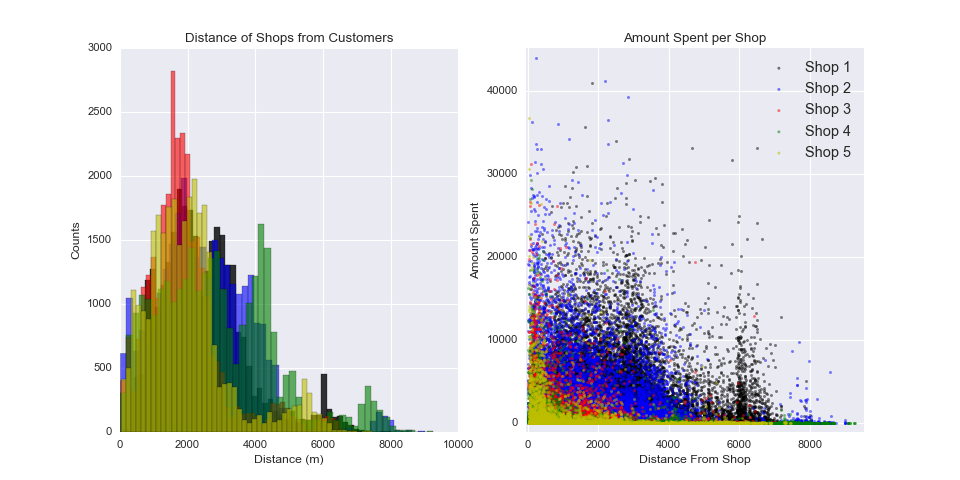

In [13]:
#Now I'll plot two figures. The first is a histogram of the distances of the customers from each store.

bins= 50
distances= ['Shop 1', 'Shop 2', 'Shop 3', 'Shop 4', 'Shop 5']

figure, ax = plt.subplots(1,2, figsize=(12,6))#Set figure sizes

plt.subplot(1,2,1)
plt.hist(train['distance_shop_1'], bins= bins, color= 'k', alpha= 0.8)
plt.hist(train['distance_shop_2'], bins= bins, color= 'b', alpha= 0.6)
plt.hist(train['distance_shop_3'], bins= bins, color= 'r', alpha= 0.6)
plt.hist(train['distance_shop_4'], bins= bins, color= 'g', alpha= 0.6)
plt.hist(train['distance_shop_5'], bins= bins, color= 'y', alpha= 0.6)
#plt.legend([[train['distance_shop_1'],train['distance_shop_2'], train['distance_shop_3']],
           #train['distance_shop_4'], train['distance_shop_5']],  ['Logistic Regression Model','Random Forest Model', 'Random Guess', 'a', 'b'], loc=4, fontsize= 13)
plt.title('Distance of Shops from Customers')
plt.xlabel('Distance (m)')
plt.ylabel('Counts')

plt.subplot(1,2,2)
shop1scatter= plt.scatter(train['distance_shop_1'], train['amount_purchased_shop_1'], marker= '.', color= 'k', alpha= 0.5, label= 'Shop 1')
shop2scatter= plt.scatter(train['distance_shop_2'], train['amount_purchased_shop_2'], marker= '.', color= 'b', alpha= 0.5, label= 'Shop 2')
shop3scatter= plt.scatter(train['distance_shop_3'], train['amount_purchased_shop_3'], marker= '.', color= 'r', alpha= 0.5, label= 'Shop 3')
shop4scatter= plt.scatter(train['distance_shop_4'], train['amount_purchased_shop_4'], marker= '.', color= 'g', alpha= 0.5, label= 'Shop 4')
shop5scatter= plt.scatter(train['distance_shop_5'], train['amount_purchased_shop_5'], marker= '.', color= 'y', alpha= 0.5, label= 'Shop 5')
plt.title('Amount Spent per Shop')
plt.xlabel('Distance From Shop')
plt.ylabel('Amount Spent')
plt.legend(handles=[shop1scatter, shop2scatter, shop3scatter, shop4scatter, shop5scatter], fontsize= 13)

The shops all have customers visiting from roughly the same distances (left), though some shops (green, shop 4) have customers coming from longer distances. On the right scatterplot we can see that shop1 (black), and 2 (blue) are really the only shops that have customers who spend more than 5,000 euros past 5,000 m from their homes. Since these are not density plots, it's hard to determine if this also corresponds to higher density of sales (they could have hte same number of sales but at different distances). Let's find this info by comparing total sales and items sold per shop.

### Understanding sales by shops

In [14]:
#Now let's calculate total sale amount, and volume for each shop

sumShop1= train['amount_purchased_shop_1'].sum()
sumShop2= train['amount_purchased_shop_2'].sum()
sumShop3= train['amount_purchased_shop_3'].sum()
sumShop4= train['amount_purchased_shop_4'].sum()
sumShop5= train['amount_purchased_shop_5'].sum()

itemsShop1= train['products_purchased_shop_1'].sum()
itemsShop2= train['products_purchased_shop_2'].sum()
itemsShop3= train['products_purchased_shop_3'].sum()
itemsShop4= train['products_purchased_shop_4'].sum()
itemsShop5= train['products_purchased_shop_5'].sum()

print 'Sum shop 1 (thousands of Euros): ', sumShop1/1000, 'Items (thousands): ', itemsShop1/1000 
print 'Sum shop 2: ',sumShop2/1000, 'Items: ', itemsShop2/1000   
print 'Sum shop 3: ',sumShop3/1000, 'Items: ', itemsShop3/1000   
print 'Sum shop 4: ',sumShop4/1000, 'Items: ', itemsShop4/1000   
print 'Sum shop 5: ',sumShop5/1000, 'Items: ', itemsShop5/1000  

Sum shop 1 (thousands of Euros):  69547.185076 Items (thousands):  26730
Sum shop 2:  41725.9811798 Items:  18342
Sum shop 3:  8911.3431735 Items:  4607
Sum shop 4:  3362.82513986 Items:  1726
Sum shop 5:  4258.89930268 Items:  2233


Wow, so Shop1 and 2 have much larger total sales but they also happen to have the largest number of total items sold!

My intuition would suggest that this could be because shop1 and 2 are large retailers with general items being sold, while shop 3-5 could be specialized. If we decide to calculate the average spent per item, we can try to determine what type of items they sell at each shop. 

In [15]:
avgpriceShop1= train['avg_price_shop_1'].mean()
avgpriceShop2= train['avg_price_shop_2'].mean()
avgpriceShop3= train['avg_price_shop_3'].mean()
avgpriceShop4= train['avg_price_shop_4'].mean()
avgpriceShop5= train['avg_price_shop_5'].mean()

print 'Average item price (euro) for shops 1,2,3,4,5: ', avgpriceShop1, avgpriceShop2, avgpriceShop3, avgpriceShop4, avgpriceShop5

Average item price (euro) for shops 1,2,3,4,5:  4.77084071458 2.3672966714 0.763742274432 0.419780972926 0.446799707655


So shops 3-5 have very small purchases that occur there (under a Euro), while shops 1 and 2 sell items at least 3-10 times the price of 3,4, and 5. Let's see if there are additional correlations between our features. So it seems apparent that 1-2 are large retailers that also have more expensive items. If stores 3-5 wanted to improve amount_spent by all customers, what features would they have to focus on? Let's try looking at the features that have strong correlations with amount_purchased (row index 6).

In [16]:
corrTable= train.corr()
plt.imshow(corrTable, interpolation='nearest', cmap='viridis')
plt.colorbar(label='Correlation of Features')

## Predicting Amounts Purchased

From the persepective of the company, the target variable would be the amounts_purchased. Let's see if we can visualize how the other variables compare to it. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

#We'll first normalize our training data, create a random forest object and finally fit it with a random forest classifier
#trainNormX= preprocessing.normalize(train.ix[:, train.columns != 'amount_purchased'])
trainNormX= train.drop('customer_id',1)

trainY= trainNormX['amount_purchased']

#print type(trainNormX), type(trainY)
forestModel= RandomForestClassifier(n_estimators= 100, random_state= 42)#Include all four features
forestModel.fit(trainNormX.ix[:, trainNormX.columns != 'amount_purchased'], trainY)

ValueError: Unknown label type: array([[  8.61156000e+02],
       [  2.31200000e+00],
       [  9.37066000e+02],
       ..., 
       [  4.41574800e+03],
       [  2.77280000e+01],
       [  1.05267300e+03]])

Don't understand error (I've been able to do this before just fine). You can see that it's having trouble cause the elements inside are arrays, not values.  Tried converting trainY to np.array but I get the same error. Changing the dimensions also gives the same problems. Wasted too much time troubleshooting this, next item on list of priorities.

In [150]:
def cdfPlot(numArray):
    '''Takes in an array and creates a cumulative 
    distribution function (CDF) plot.
    '''
    
    sortArray= sorted(numArray)
    step= 1.0/len(numArray)
    scaledArray= np.arange(0,1,step)
    
    
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    plt.style.use('fivethirtyeight')

    plt.plot(sortArray,scaledArray)
    
    plt.title('Change Title', fontsize= 21, fontweight= 'bold')
    
    plt.xlabel('Your Label Here', fontsize=17,fontweight= 'bold')
    plt.ylabel('Your Label Here', fontsize=17, fontweight= 'bold')
    ax.tick_params(axis='both', which='major', labelsize=13, labelcolor= '#7c7e82')#Adjust size of x,y labels
    ax.tick_params(axis='both', which='major', labelsize=13)